Используем ID фильма и ID пользователя для создания соответствующих эмбеддингов. Эти эмбеддинги создаются в процессе обучения модели вместе с другими параметрами. Получив эмбеддинги, построим модель K-Nearest Neighbor (KNN). Затем, для пользователя, можем получить его эмбеддинг из нашей нейросетевой модели. Используя этот эмбеддинг для поиска в базе данных KNN и для рекомендации этому пользователю K лучших фильмов

Следует отметить, что этот подход не сможет работать с неизвестными пользователями. То есть, если ID пользователя отсутствовал в процессе обучения модели, не получиться рекомендовать фильмы для этого пользователя

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import collections

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка и подготовка данных

In [2]:
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

In [3]:
# Построение базового датафрейма путем объединения рейтингов и фильмов по общему столбцу movieId
df = pd.merge(ratings, movies, on="movieId").drop(columns='timestamp')

In [4]:
# Извлечение каждого жанра каждого фильма
genres = movies.genres.str.split("|")

In [5]:
# Добавить признаки жанров в качестве столбца для каждого жанра и установите значение 1 если
# есть наличие признака, в противном случае установите значение 0
allgenres = set(genres.sum()) # найти уникальные жанры
for genre in allgenres:
    df[genre] = df["genres"].apply(lambda movie_genres: 1 if genre in movie_genres else 0)

In [6]:
# Поскольку идентификаторы начинаются с 1, мы сдвигаем их, чтобы они начинались с 0
df["movieId"] = df["movieId"].apply(lambda x: int(x-1))
df["userId"] = df["userId"].apply(lambda x: int(x-1))

In [7]:
df.drop(columns=['genres'], inplace=True)

In [8]:
df

,userId,movieId,rating,title,Thriller,IMAX,Film-Noir,Musical,Drama,Comedy,...,Fantasy,Children,Action,Sci-Fi,Romance,(no genres listed),Horror,Western,Documentary,Animation
0,0,0,4.0,Toy Story (1995),0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
1,4,0,4.0,Toy Story (1995),0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
2,6,0,4.5,Toy Story (1995),0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
3,14,0,2.5,Toy Story (1995),0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
4,16,0,4.5,Toy Story (1995),0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,609,160340,2.5,Bloodmoon (1997),1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
100832,609,160526,4.5,Sympathy for the Underdog (1971),0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
100833,609,160835,3.0,Hazard (2005),1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
100834,609,163936,3.5,Blair Witch (2016),1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
train, test = train_test_split(df, test_size=0.15, random_state=7062023)

In [10]:
ROW_COUNT = train.shape[0]

In [11]:
EMBEDDING_SIZE = 10
NUM_USERS = df['userId'].nunique()
NUM_MOVIES = df['movieId'].nunique()

In [12]:
train.head()

,userId,movieId,rating,title,Thriller,IMAX,Film-Noir,Musical,Drama,Comedy,...,Fantasy,Children,Action,Sci-Fi,Romance,(no genres listed),Horror,Western,Documentary,Animation
100495,602,2864,4.0,Sugar Town (1999),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17303,444,68156,4.5,Inglourious Basterds (2009),0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
29931,19,238,4.5,"Goofy Movie, A (1995)",0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
54533,444,34404,4.0,Serenity (2005),0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
79799,386,8622,3.0,Roxanne (1987),0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [13]:
UNIQUE_MOVIE_IDS = df['movieId'].unique()

# Определение модели
Определим четырехслойную глубокую нейронную сеть. Внутри модели есть две подмодели - movie_model и user_model. Определяем их так, чтобы после обучения, могли бы извлекать соответствующие вложения фильма или пользователя через эти подмодели соответственно. Так как у нас не так много данных6 то определим только 4 слоя у модели, что бы обучение было побыстрее. Но если было больше данных, то можем построить более глубокую модель для большее извлечение фич

В качестве функции потерь используем классический MAE. MAE является наиболее популярным и широко используемым — это мера отклонения рекомендации от фактической

In [14]:
def embeddin_rec(embedding_size, num_movies, num_users, row_count):

    movie_input = keras.Input(shape=(1, ), name='movieId')
    # слой эмбеддинга для фильмов
    movie_emb = layers.Embedding(
        output_dim=embedding_size,
        input_dim=num_movies,
        input_length=row_count,
        name='movie_emb'
    )(movie_input)

    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)
    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)

    user_input = keras.Input(shape=(1, ), name='userId')
    # слой эмбеддинга для пользователей
    user_emb = layers.Embedding(
        output_dim=embedding_size,
        input_dim=num_users,
        input_length=row_count,
        name='user_emb'
    )(user_input)

    user_vec = layers.Flatten(name='FlattenUser')(user_emb)
    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    merged = layers.Dot(name='dot_product', normalize=True, axes=2)([movie_emb, user_emb])

    dense_1 = layers.Dense(70, name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2, name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50, name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2, name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20, name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2, name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10, name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu")(dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam, loss='mean_absolute_error')

    return model, movie_model, user_model

In [15]:
model, movie_model, user_model = embeddin_rec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

# Обучение модели

In [16]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit(
    [train.movieId, train.userId],
    train.rating,
    batch_size=100,
    epochs=50,
    validation_data=([test.movieId, test.userId], test.rating),
    verbose=1,
    callbacks = callbacks
)

Epoch 1/50
858/858 [==============================] - 27s 23ms/step - loss: 0.9747 - val_loss: 0.8298
Epoch 2/50
858/858 [==============================] - 7s 8ms/step - loss: 0.8581 - val_loss: 0.8301
Epoch 3/50
858/858 [==============================] - 7s 8ms/step - loss: 0.8416 - val_loss: 0.8287
Epoch 4/50
858/858 [==============================] - 6s 7ms/step - loss: 0.8160 - val_loss: 0.7785
Epoch 5/50
858/858 [==============================] - 7s 9ms/step - loss: 0.7027 - val_loss: 0.7414
Epoch 6/50
858/858 [==============================] - 7s 8ms/step - loss: 0.6444 - val_loss: 0.7454
Epoch 7/50
858/858 [==============================] - 7s 8ms/step - loss: 0.6148 - val_loss: 0.7344
Epoch 8/50
858/858 [==============================] - 8s 9ms/step - loss: 0.5966 - val_loss: 0.7456
Epoch 9/50
858/858 [==============================] - 6s 8ms/step - loss: 0.5836 - val_loss: 0.7438
Epoch 10/50
858/858 [==============================] - 7s 9ms/step - loss: 0.5736 - val_loss: 0.74

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movieId (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 userId (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 movie_emb (Embedding)          (None, 1, 10)        97240       ['movieId[0][0]']                
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        6100        ['userId[0][0]']                 
                                                                                            

# Визуализация архитектуры модели

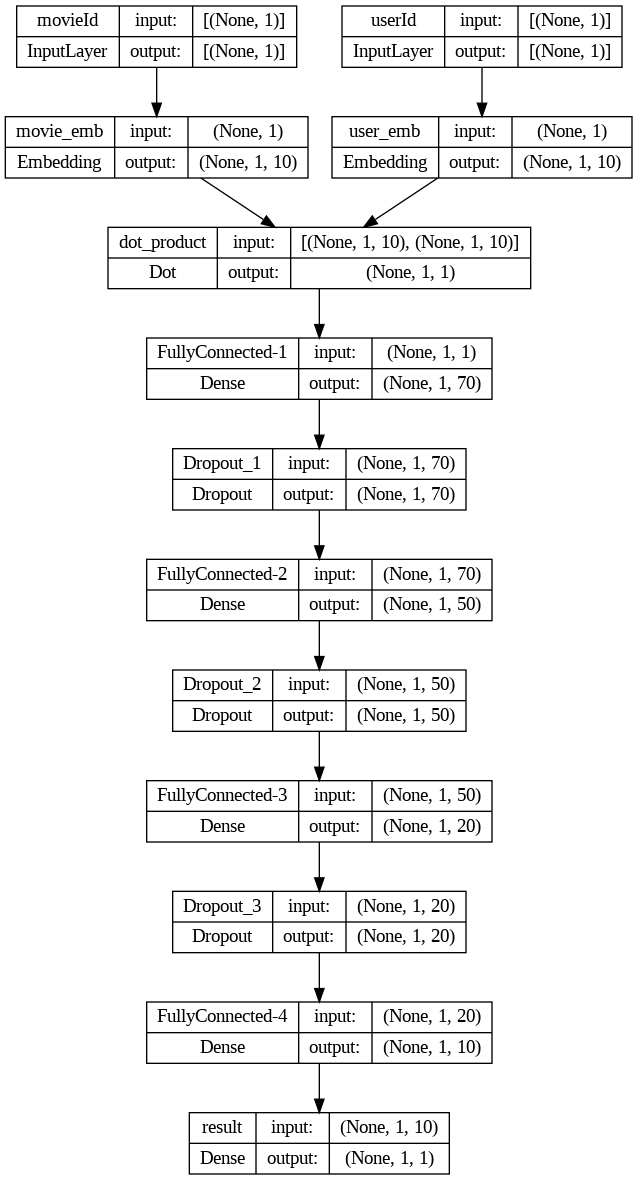

In [18]:
keras.utils.plot_model(model, show_shapes=True)

# Построение кривой потерь

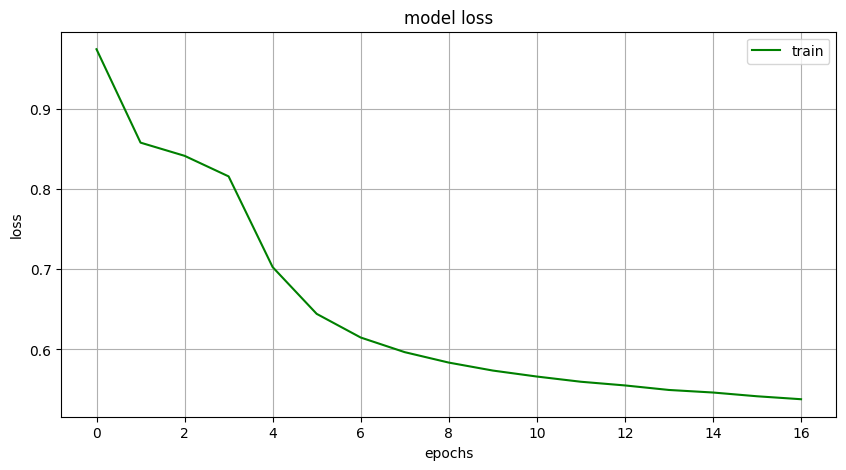

In [19]:
rcParams['figure.figsize'] = 10, 5

plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

# Nearest Neighbor Recommendation

In [20]:
TEST_USER_ID = 200
TEST_MOVIE_ID = 123

# Извлечение эмбеддингов фильмов

In [21]:
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [22]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1, -1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step


# Проверка эмбеддингов
Один из способов проверки эмбеддингов - построить график. График покажет, что фильмы с похожим рейтингом (так как рейтинг был нашей целью) находятся рядом в пространстве эмбеддингов.

In [23]:
def tsne_plot(movie_embed, size=NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.asarray(movie_embed[:size]))
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0, size))
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

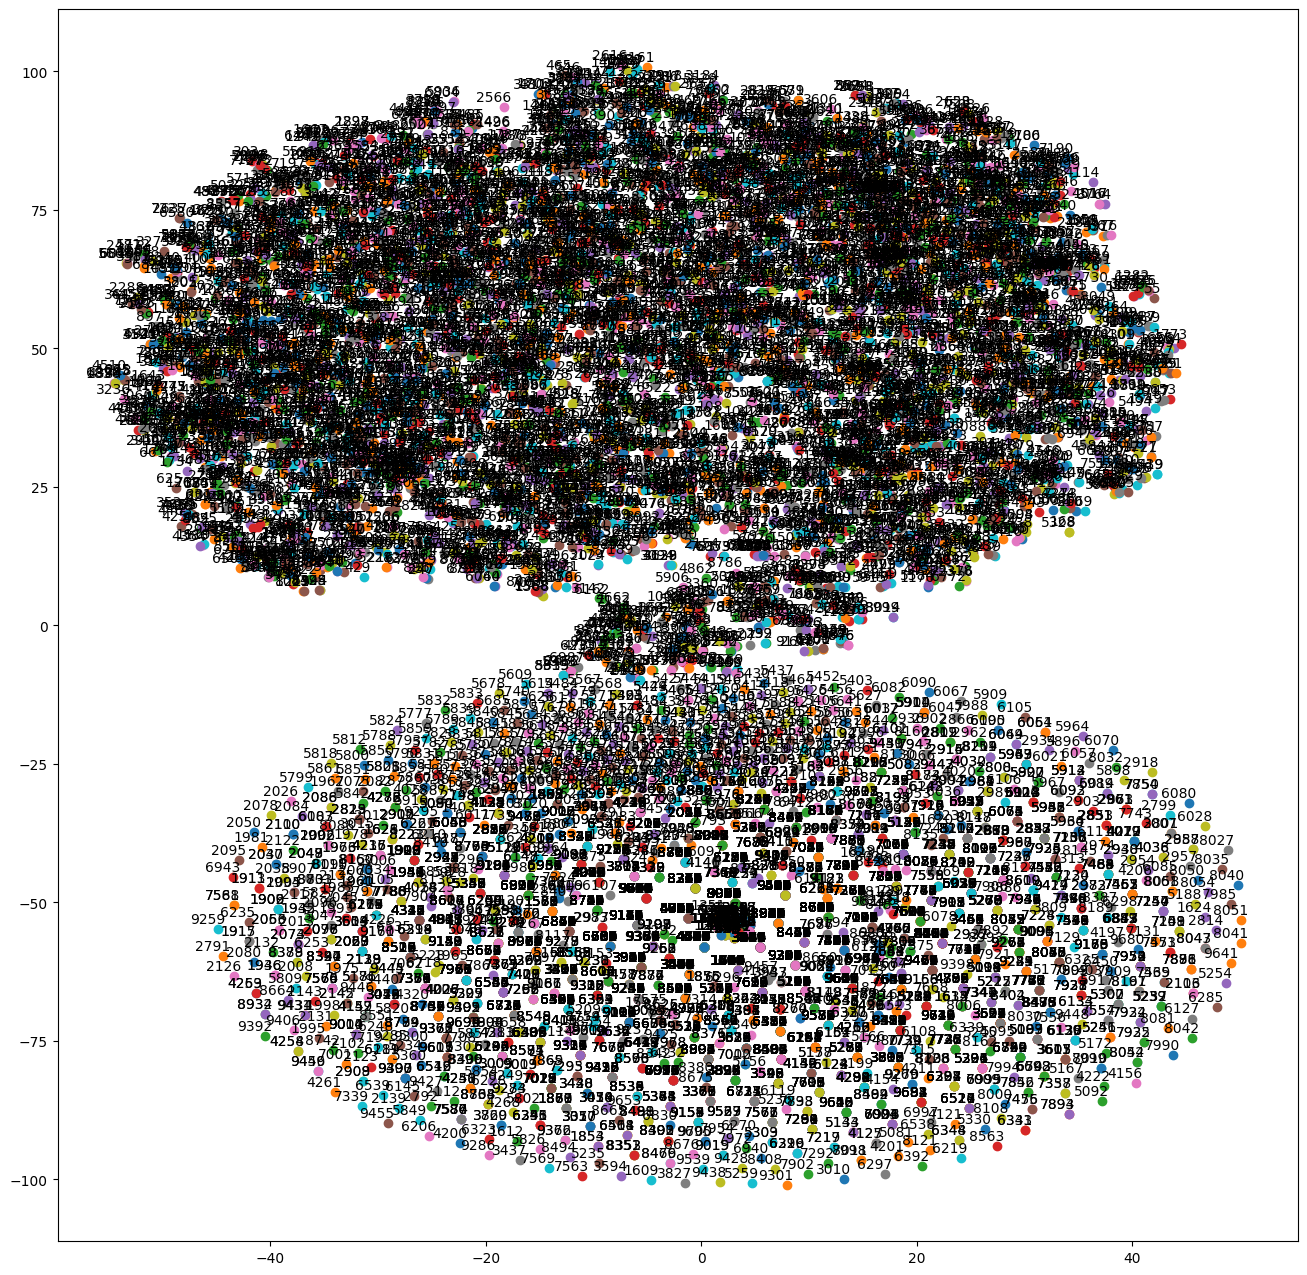

In [24]:
tsne_plot(MOVIE_EMBEDDING_LIST)

Так как верхний график менее информативный, возьмем только первые 400 фильмов. И построим новый график

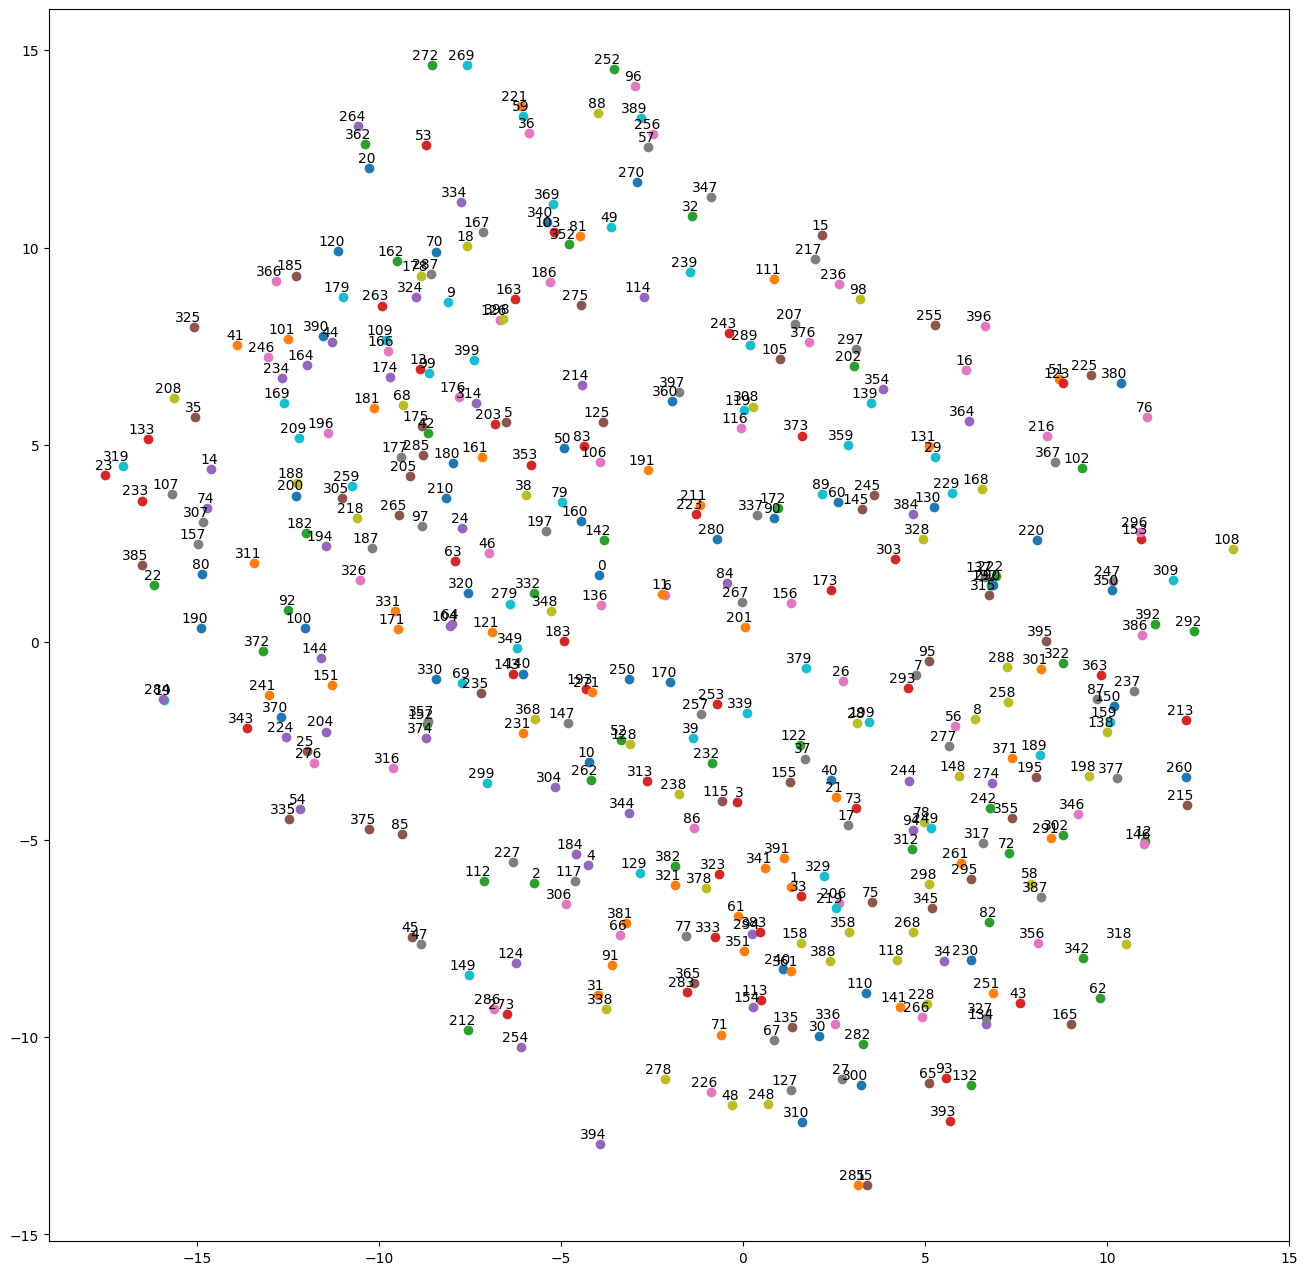

In [25]:
tsne_plot(MOVIE_EMBEDDING_LIST, 400)

Возьмем две оранжевые точки, которые лежат очень близко в левом углу(331, 171), и оранжевую точку в правом углу(251). И можем убедиться, что средний рейтинги для филмов с id 331 и 171 находятся ближе, чем средний рейтинг фильма с id 251. 

In [43]:
np.average(df.loc[df['movieId'] == 331, 'rating'], axis=0)

2.8333333333333335

In [44]:
np.average(df.loc[df['movieId'] == 171, 'rating'], axis=0)

2.6792452830188678

In [46]:
np.average(df.loc[df['movieId'] == 251, 'rating'], axis=0)

3.453488372093023

# Топ-К кандидатов с использованием K-Nearest Neighbor
После того, как получили эмбеддинги, можем применить алгоритм ближайших соседей для рекомендации фильмов пользователям. Можем получить user_embedding из user_id и выяснить, какие фильмы близки к user_embedding в пространстве эмбеддинг. Для этого используем алгоритм K-Nearest Neighbor

In [29]:
knn_train_label = UNIQUE_MOVIE_IDS

In [30]:
# Создаем KNN модель
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(n_neighbors=11)

In [31]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10, 1)
    df_indices = pd.DataFrame(indices, columns = ['movieId'])
    return df_indices.merge(movies, on='movieId', how='inner', suffixes=['_u', '_m'])['title']

In [32]:
# Используем поиск для этого пользователя
TEST_USER_ID

200

In [33]:
# получить эмбеддинг этого пользователя
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1, -1)[0]

1/1 [==============================] - 0s 74ms/step


In [34]:
# Получаем рекомендацию
recommend_movies(user_embedding)

0       In the Heat of the Night (1967)
1             Living in Oblivion (1995)
2                           Kids (1995)
3               Jean de Florette (1986)
4                Dead Presidents (1995)
5    French Twist (Gazon maudit) (1995)
6                          Alice (1990)
7     NeverEnding Story III, The (1994)
8                   Dante's Peak (1997)
Name: title, dtype: object